# Author analysis


In [41]:
import re
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

DATA_FOLDER = "../data/"

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [2]:
articles = pd.read_json(DATA_FOLDER + "filtered.jsonl", lines=True)

In [3]:
articles.head(10)

,date,fulltext,id,pages,title,type
0,1900-10-15,CONFÉDÉRATION S 01 SSE Militaire. — Le départe...,GDL-1900-10-15-a-i0014,[2],CONFÉDÉRATION S01SSE,ar
1,1900-02-03,CONFÉDÉRATION SOISSE Nominations. — Le Conseil...,GDL-1900-02-03-a-i0013,[2],CONFÉDÉRATION SOISSE,ar
2,1900-08-06,CONFÉDÉRATION SUISSE Drainage des écus. — D'ap...,GDL-1900-08-06-a-i0014,[2],CONFÉDÉRATION SUISSE,ar
3,1900-02-15,"Le drainage des éens. Genève, 14 février. Lund...",GDL-1900-02-15-a-i0006,[1],Le drainage des éens.,ar
4,1900-06-11,CONFÉDÉRATION SOISS Sonnerie de cloches. — Le ...,GDL-1900-06-11-a-i0015,[2],CONFÉDÉRATION SOISS,ar
5,1900-05-25,CONFÉDÉRATION SUISSE Expulsions. — Le Conseil ...,GDL-1900-05-25-a-i0010,[2],CONFÉDÉRATION SUISSE,ar
6,1900-05-26,"BULLETIN POLITIQUE Lausanne, 26 mai 1900. lie ...",GDL-1900-05-26-a-i0002,[1],BULLETIN POLITIQUE,ar
7,1900-09-08,KOUVELiES DES CANTONS BERNE. — L'institut vacc...,GDL-1900-09-08-a-i0016,[2],KOUVELiES DES CANTONS,ar
8,1900-11-22,CONFÉDÉRATION SUISSE Budget. — La commission d...,GDL-1900-11-22-a-i0013,[2],CONFÉDÉRATION SUISSE,ar
9,1900-11-24,CONFÉDÉRATION SUISSE Chemins de fer. — Le Cons...,GDL-1900-11-24-a-i0015,[2],CONFÉDÉRATION SUISSE Chemins de fer. — Le Cons...,ar


In [4]:
len(articles)

34582

In [5]:
jdg_indexes = articles.id.str.contains("JDG")
gdl_indexes = articles.id.str.contains("GDL")

print(
    "JDG: ",
    jdg_indexes.sum(),
    "\nGDL: ",
    gdl_indexes.sum()
)

JDG:  13487 
GDL:  21095


In [6]:
banking_indexes =  articles.fulltext.str.lower().str.contains("secret bancaire")
banking_indexes.sum()

1737

## Different types of authors

#### Agencies

- **ATS** Agence télégraphique suisse
- **AFP** Agence France-Presse
- **Reuters** 
- **AP**: Associated press

In [7]:
agency_indexes = articles.fulltext.str.lower().str.contains(
    r"\((a\.?t\.?s|ap|a\.?f\.?p|reuter|associated press).?\)"
)
agency_indexes.sum()


/Users/yann/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


6377

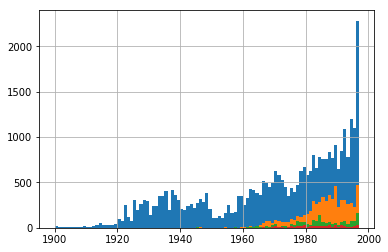

In [31]:
def year_hist(series):
    year_series = series.date.dt.year
    years = year_series.max() - year_series.min() 
    return year_series.hist(bins=years)


year_hist(articles)
year_hist(articles[agency_indexes])
year_hist(articles[banking_indexes])
year_hist(articles[banking_indexes & agency_indexes]);

In [9]:
(banking_indexes & agency_indexes).sum() / banking_indexes.sum()

0.2872769142199194

In [10]:
agency_indexes.sum() / articles.shape[0]

0.18440229020877913

#### Authors

In [11]:
fulltext = articles[articles.id.str.contains("JDG-1987-08-13")].iloc[0].fulltext
fulltext

'MARCHÉ DES CAPITAUX Syndicats d\'émissions : les grandes banques libéralisent ,.\'-il. : L\'. ,.... „, ; ,. : .,, (. 1 \'" Les trois grandes banques suisses ont annonce mercredi qu\'elles s\'apprêtaient à ouvrir sous certaines conditions, leur syndicat d\'émission d\'emprunts sur le marché suisse des capitaux, à des émissions dirigées par des banques étrangères établies en Suisse. Des détails sur cène mesure de libéralisation, qui répond à l\'internationalisation croissante du marché des capitaux, seront gués ultérieurement, ont annoncé les trois grandes banques (UBS, Crédit Suisse et SBS) dans un communiqué. J .-L. L. '

In [12]:
initials_pattern = r"\w{2,}\s*\.\s*((\s*\-?\w\s*\.\s*){2,4})$"
re.search(initials_pattern, fulltext)

<_sre.SRE_Match object; span=(596, 618), match='communiqué. J .-L. L. '>

In [13]:
initials_matches = (
    articles.fulltext.str.extract(initials_pattern)
    .dropna()[0]
    .apply(lambda s: s.upper().replace(" ", ""))
)

In [14]:
initials_indexes = articles.index.isin(initials_matches.index)
len(initials_matches)

913

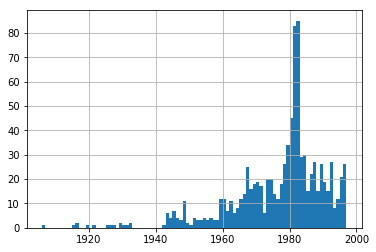

In [32]:
year_hist(articles[initials_indexes]);

In [19]:
initials_counts = (
    pd.DataFrame(
        {
            "total": initials_matches.value_counts(),
            "JDG": initials_matches[jdg_indexes].value_counts(),
            "GDL": initials_matches[gdl_indexes].value_counts(),
        }
    )
    .sort_values("total", ascending=False)
    .fillna(0)
    .astype(int)
)


initials_counts.head(10)

,total,JDG,GDL
J.-L.L.,154,75,79
F.L.,135,1,134
J.R.,34,16,18
G.R.,30,0,30
S.A.,28,21,7
H.V.,24,24,0
A.K.,23,23,0
J.-S.E.,19,12,7
A.V.,19,12,7
M.-J.K.,18,9,9


In [20]:
initials_counts.sort_values("GDL", ascending=False).head()

,total,JDG,GDL
F.L.,135,1,134
J.-L.L.,154,75,79
G.R.,30,0,30
J.R.,34,16,18
F.W.,11,0,11


In [21]:
initials_counts.sort_values("JDG", ascending=False).head()

,total,JDG,GDL
J.-L.L.,154,75,79
H.V.,24,24,0
A.K.,23,23,0
S.A.,28,21,7
J.R.,34,16,18


In [22]:
frequent_initials = initials_counts.head(20).index

In [23]:
(initials_indexes & agency_indexes).sum()

21

In [24]:
with open(DATA_FOLDER + "authors_jdg.txt", "r") as f:
    authors_jdg_list = f.read()

# a map from initials to the set of authors with thos initials
authors_jdg = {}
for author in authors_jdg_list.split("\n"):
    initials = ""
    for name_part in author.split(" "):
        if "-" in name_part:
            single_name = name_part.split("-")
            initials += single_name[0][:1] + ".-" + single_name[1][:1] + "."
        else:
            initials += name_part[:1] + "."

    if len(initials) > 1:
        if initials in authors_jdg:
            authors_jdg[initials].add(author)
        else:
            authors_jdg[initials] = set([author])


for initials in frequent_initials:
    if initials in authors_jdg:
        print(authors_jdg[initials])
    else:
        print(initials)

{'Jean-Luc Lederrey'}
F.L.
{'Jean Roussel'}
G.R.
{'Sylvie Arsever'}
{'Henri Villy'}
{'André Klopmann'}
{'Jacques-Simon Eggly'}
{'André Vallana', 'Anton Vos'}
M.-J.K.
{'Pierre Novello'}
V.S.
R.-F.P.
A.-M.L.
D.-S.M.
{'Pascal Garcin'}
H.S.
G.D.
{'Françoise Weilhammer'}
P.H.


#### Author's full name

In [25]:
from functools import reduce

authors_jdg_set = reduce(lambda s1, s2: s1 | s2, authors_jdg.values())
jdg_pattern = "(" + "|".join(authors_jdg_set) + ")"

full_name = (
    articles.fulltext.str.extract(jdg_pattern, flags=re.IGNORECASE)[0]
    .dropna()
    .str.lower()
    .str.strip()
)

1772
2670


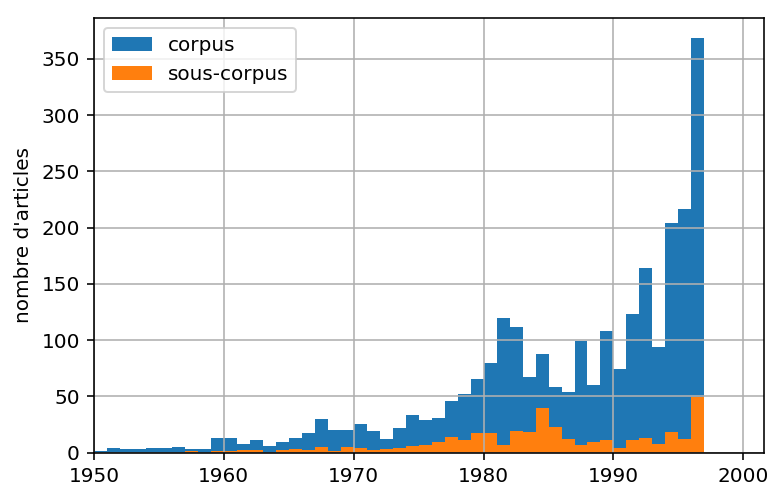

In [70]:
full_name_indexes = articles.index.isin(full_name.index)
print(full_name_indexes.sum())

attributed_indexes = full_name_indexes | initials_indexes
print(attributed_indexes.sum())

year_hist(articles[attributed_indexes]);
year_hist(articles[attributed_indexes & banking_indexes]);

plt.axis(xmin=1950);
plt.ylabel("nombre d'articles")
plt.legend(["corpus", "sous-corpus"]);

plt.savefig("../rapport/methodology/author_attributed.png", dpi=200)

In [22]:
full_name.value_counts()

jean-luc lederrey      510
pierre novello         190
jacques-simon eggly    156
andré vallana          144
marian stepczynski     134
sylvie arsever          89
françoise buffat        59
christian campiche      37
mehmet gultas           27
pascal garcin           27
ignace jeannerat        27
françoise blaser        25
esther mamarbachi       25
bernard wuthrich        22
robin bleeker           22
denise jeanmonod        20
olivier reverdin        17
jasmine audemars        17
michel petitpierre      13
antoine maurice         12
roger de diesbach       10
roland ecoffey          10
jean-claude buffle       9
fati mansour             9
luis lema                9
antoine bosshard         9
patricia briel           9
jean roussel             8
pascal praplan           7
bernard béguin           7
                      ... 
alain r. walon           5
philippa de roten        5
isabelle martin          5
andré klopmann           5
christophe hans          4
christian bernet         4
t

In [68]:
full_name[gdl_indexes & banking_indexes & (articles.date.dt.year <= 1990)].value_counts()

jean-luc lederrey      29
jacques-simon eggly    26
françoise blaser        6
sylvie arsever          4
pierre novello          4
isabelle martin         2
pascal garcin           1
paul ladame             1
olivier reverdin        1
nuno sepulveda          1
françoise buffat        1
jean-claude poulin      1
jasmine audemars        1
Name: 0, dtype: int64

In [69]:
initials_matches[gdl_indexes & banking_indexes & (articles.date.dt.year <= 1990)].value_counts()

J.-L.L.    16
D.-S.M.     6
J.R.        5
A.-M.L.     3
H.S.        3
J.-S.E.     2
F.W.        2
G.P.        2
S.A.        2
R.R.        1
J.S.E.      1
M.-J.K.     1
P.-A.S.     1
G.D.        1
J.-P.G.     1
-H.P.       1
C.-E.L.     1
J.A.        1
F.L.        1
A.W.        1
D.A.        1
X.P.        1
M.S.        1
J.S.        1
R.L.        1
-E.R.       1
J.-C.R.     1
Name: 0, dtype: int64

#### Rédaction

In [24]:
red_indexes = articles.fulltext.str.contains("\([R|r][é|e]d\.?\)")
red_indexes.sum()

261

In [25]:
(red_indexes & (ats_indexes | afp_indexes | initials_indexes)).sum()

NameError: name 'ats_indexes' is not defined

--> too much overlap! Don't use.